In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

raw_data = "C:/Users/ASUS/Desktop/Python_project/stock_news_df.csv"
datafile = pd.read_csv(raw_data)

In [68]:
df_BYD, df_LG, df_CATL, df_Tesla, df_panasonic = [datafile.query(f'기업명 == "{company}"') for company in ["BYD", "LG 에너지 솔루션", "CATL", "테슬라", "파나소닉"]]

In [69]:
df_Tesla.reset_index(drop=True, inplace=True)

In [70]:
df_Tesla.drop(columns=['기업명', 'keyword', 'title', 'link', 'summary', '전처리'], inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_31824\199027254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Tesla.drop(columns=['기업명', 'keyword', 'title', 'link', 'summary', '전처리'], inplace=True)


Train data shape: (47186, 10, 5), Test data shape: (11797, 10, 5)
Epoch 1/50


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1475/1475 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.5097 - val_loss: 0.2351 - learning_rate: 0.0010
Epoch 2/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - loss: 0.0975 - val_loss: 0.1267 - learning_rate: 0.0010
Epoch 3/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0319 - val_loss: 0.0641 - learning_rate: 0.0010
Epoch 4/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.0097 - val_loss: 0.0720 - learning_rate: 0.0010
Epoch 5/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0029 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 6/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0017 - val_loss: 0.0971 - learning_rate: 0.0010
Epoch 7/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0016 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 8/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0016 - val_loss: 0.0143 - learning_rate: 0.0010
Epoch 9/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0016 - val_loss: 0.0140 - learning_

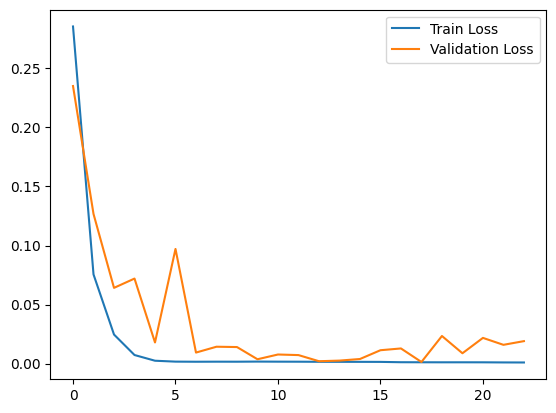

In [71]:
# 데이터 로드
df = df_Tesla.copy()

# 날짜 변환
df['date'] = pd.to_datetime(df['date'])

# 감성결과를 숫자로 변환 (예: 부정=0, 중립=1, 긍정=2)
label_encoder = LabelEncoder()
df['감성결과'] = label_encoder.fit_transform(df['감성결과'])  # 부정(0), 중립(1), 긍정(2)

# 필요한 변수 선택
features = ['감성결과', '시가', '고가', '거래량', '변동 %']
target = '종가'

# 데이터 정규화 (MinMax Scaling)
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df[target] = scaler.fit_transform(df[[target]])

# 시계열 데이터 만들기
def create_sequences(data, target, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # 최근 20일 데이터를 기반으로 예측

# 시계열 데이터 변환
X, y = create_sequences(df[features].values, df[target].values, seq_length)

# 데이터 분할 (80% 학습, 20% 테스트)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train data shape: {X_train.shape}, Test data shape: {X_test.shape}")

# Early Stopping & ReduceLROnPlateau 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# 개선된 LSTM 모델 생성
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, len(features)), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1)  # 종가 예측
])

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# 모델 학습
history = model.fit(
    X_train, y_train, 
    epochs=50, batch_size=32, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# 학습 과정 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
RMSE: 9.9328
MAE: 7.4190


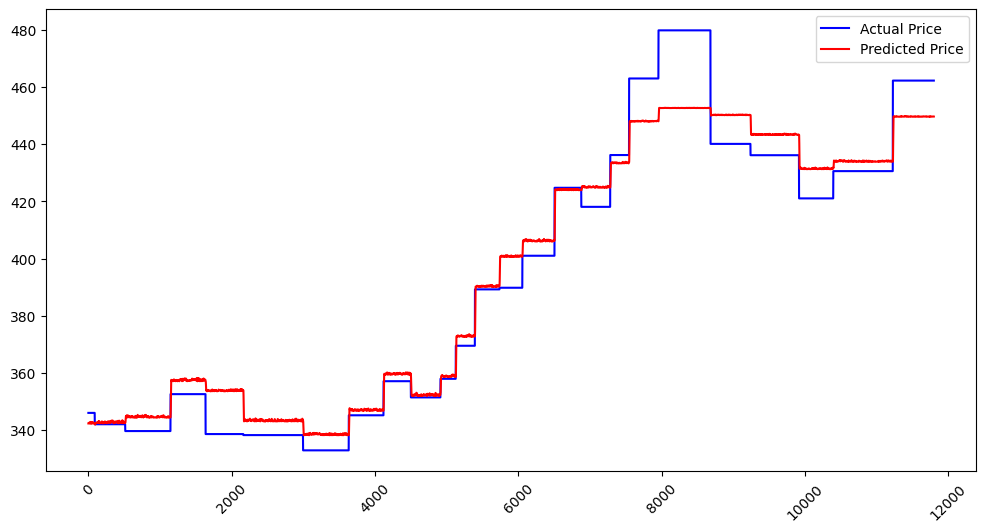

In [72]:
# 예측 수행
y_pred = model.predict(X_test)

# 정규화 해제 (Inverse Transform)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# RMSE 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual Price", color='blue')
plt.plot(y_pred_inv, label="Predicted Price", color='red')
plt.xticks(rotation=45)
plt.legend()
plt.show()